In [1]:
import sys
sys.path.append('../input/U-2-Net/')
sys.path.append('../')

In [2]:
# from u2net_test import extract
# extract('../input/petfinder-pawpularity-score/train', '../input/petfinder-pawpularity-score/train_U2NET')
# extract('../input/petfinder-pawpularity-score/test', '../input/petfinder-pawpularity-score/test_U2NET')

In [3]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import IncrementalPCA
from tqdm.notebook import tqdm
import torch.nn.functional as F
from albumentations.pytorch.transforms import ToTensorV2
import seaborn as sns
import PIL.Image as Image
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import time
import pandas_profiling as pdp
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from utils.util import *
from utils.losses import *
import torch.nn as nn
import transformers as T
import albumentations
import pandas as pd
import cv2
import numpy as np
import timm
import torch.nn as nn
from utils.util import EarlyStopping
from sklearn import metrics
import torch
from tqdm import tqdm
import math
import albumentations
import tez
import torch.optim as optim
import warnings
warnings.simplefilter('ignore')

In [4]:
class CONFIG:
    DATA_PATH = Path('../input/petfinder-pawpularity-score')
    OUTPUT_DIR = Path('../output/8')
    MODEL_NAME = 'swin_large_patch4_window12_384'
    batch_size = 64
    image_size = 384
    fold = 5
    epoch = 20
    lr = 1e-5
    device='cuda'
    training_step=False
    pretrained=True
    SEED=42
if not os.path.isdir(CONFIG.OUTPUT_DIR):
    os.makedirs(CONFIG.OUTPUT_DIR)
LOGGER = init_logger(OUTPUT_DIR=CONFIG.OUTPUT_DIR)
fix_seed(CONFIG.SEED)
pet_category = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
 'Egyptian_Mau' ,'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue' ,'Siamese',
 'Sphynx', 'american_bulldog' ,'american_pit_bull_terrier', 'basset_hound',
 'beagle', 'boxer' ,'chihuahua', 'english_cocker_spaniel', 'english_setter',
 'german_shorthaired' ,'great_pyrenees', 'havanese', 'japanese_chin',
 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian',
 'pug' ,'saint_bernard' ,'samoyed' ,'scottish_terrier', 'shiba_inu',
 'staffordshire_bull_terrier' ,'wheaten_terrier' ,'yorkshire_terrier']

In [5]:
train_df = pd.read_csv(CONFIG.DATA_PATH / 'train.csv')
train_df['path'] = train_df['Id'].map(lambda x:str(CONFIG.DATA_PATH/'train'/x)+'.jpg')
train_df['mask_path'] = train_df['Id'].map(lambda x:str(CONFIG.DATA_PATH/'train_U2NET'/x)+'.jpg')
train_df['image_size'] = train_df['path'].apply(lambda image_id : Image.open(image_id).size)
train_df['width'] = train_df['image_size'].apply(lambda x: x[0])
train_df['height'] = train_df['image_size'].apply(lambda x: x[1])

test_df = pd.read_csv(CONFIG.DATA_PATH / 'test.csv')
test_df['path'] = test_df['Id'].map(lambda x:str(CONFIG.DATA_PATH/'test'/x)+'.jpg')
test_df['mask_path'] = test_df['Id'].map(lambda x:str(CONFIG.DATA_PATH/'test_U2NET'/x)+'.jpg')
test_df['image_size'] = test_df['path'].apply(lambda image_id : Image.open(image_id).size)
test_df['width'] = test_df['image_size'].apply(lambda x: x[0])
test_df['height'] = test_df['image_size'].apply(lambda x: x[1])

train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,mask_path,image_size,width,height
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...,../input/petfinder-pawpularity-score/train_U2N...,"(405, 720)",405,720
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...,../input/petfinder-pawpularity-score/train_U2N...,"(1032, 774)",1032,774
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...,../input/petfinder-pawpularity-score/train_U2N...,"(720, 960)",720,960
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...,../input/petfinder-pawpularity-score/train_U2N...,"(405, 720)",405,720
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...,../input/petfinder-pawpularity-score/train_U2N...,"(540, 960)",540,960


In [6]:
train_df = get_train_data(train_df, train_df['Pawpularity'], n_splits = CONFIG.fold, regression=True)

In [7]:
def create_images_array(df):
    image_paths = df['path'].tolist()
    mask_paths = df['mask_path'].tolist()
    # Hog特徴のパラメータ
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (4, 4)
    cell_size = (4, 4)
    bins = 9
    # 画像群の配列を生成
    imgs=[]
    for load_img_path, load_mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        # 画像をロード, グレースケール変換
        # 色反転, 64*64にリサイズ, 1次元配列に変換
        img = cv2.imread(load_img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(load_mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)>127.5
        
        idx = np.where(mask==True)
        h_max = idx[0].min()
        h_min = idx[0].max()
        w_max = idx[1].min()
        w_min = idx[1].max()
        
        gray = gray[h_max:h_min, w_max:w_min]
        mask = mask[h_max:h_min, w_max:w_min]
        
        gray = gray * mask 
        gray = cv2.resize(gray, win_size)
        hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, bins)
        img = hog.compute(gray)
        imgs.append(img)
        
    return np.array(imgs, np.float32)

In [8]:
HOG_feature = create_images_array(train_df)
HOG_feature = HOG_feature.squeeze()

100%|███████████████████████████████████████████████████████████████| 9912/9912 [02:14<00:00, 73.76it/s]


In [208]:
from sklearn.decomposition import PCA

pca=PCA(n_components=300)
HOG_feature_50 = pca.fit_transform(HOG_feature)

In [209]:
HOG_feature_df = pd.DataFrame(HOG_feature_50, columns=[f'HOG_{str(i)}' for i in range(300)])
HOG_feature_df['Id'] = train_df['Id']

In [264]:
from sklearn.neighbors import NearestNeighbors
distance, indices = NearestNeighbors(n_neighbors=9912, metric='cosine').fit(HOG_feature_50).kneighbors(HOG_feature_50)

In [265]:
indices

array([[   0, 4823, 1516, ...,  203, 3597, 3697],
       [   1, 1801, 6917, ...,  419, 1359, 8775],
       [   2, 7698, 8969, ..., 8244, 2532, 4327],
       ...,
       [9909, 5559, 8479, ..., 9418, 2173, 8600],
       [9910, 8128, 5904, ..., 2719, 1534, 3644],
       [9911, 2076, 3173, ..., 1036, 2449, 4463]])

In [266]:
array = train_df.Pawpularity.values

In [267]:
train_df['pred']=(array[indices[:,1:]] * (1/distance[:,1:])).sum(1)/np.sum(1/distance[:,1:],axis=1)
# train_df['pred']=array[indices[:,1:]].mean(1)

In [268]:
train_df.loc[:, ['pred', 'Pawpularity']]
np.sqrt(mean_squared_error(train_df['pred'], train_df['Pawpularity']))

20.583407213089487

In [269]:
train_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,HOG_41,HOG_42,HOG_43,HOG_44,HOG_45,HOG_46,HOG_47,HOG_48,HOG_49,pred
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,-0.429494,-0.268446,0.048024,-0.997626,-0.545364,0.303333,0.584739,-0.145893,0.481144,37.993854
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,-0.302090,-0.695693,-0.115095,-0.325178,0.154479,-1.427288,0.093473,0.718824,0.050786,37.981450
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,-0.465642,0.019478,1.208080,-0.141772,0.590234,-0.208593,0.209094,-0.355684,0.081747,38.071583
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,0.782568,-0.259922,-0.524365,-0.278170,0.605977,1.041716,-0.106293,0.641015,0.926160,38.052855
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,-0.429899,-0.019896,-0.770162,-0.215753,-0.408631,-0.052556,0.643765,-0.010613,-1.391764,38.090457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,0.922148,0.301399,-0.328198,-0.595116,0.121792,-0.067224,-0.085765,-0.551625,0.728661,37.959424
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,-0.326803,0.597155,-0.239824,-0.481367,-1.461393,0.532120,0.164188,-0.194603,-0.341445,38.051796
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,-0.538586,-0.249214,-1.103529,0.137343,0.589564,0.630627,0.246536,0.606713,-1.056692,38.075097
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,-0.287996,0.378458,0.027139,-0.048751,-0.060164,0.729833,-0.054832,0.324598,1.221961,38.151130


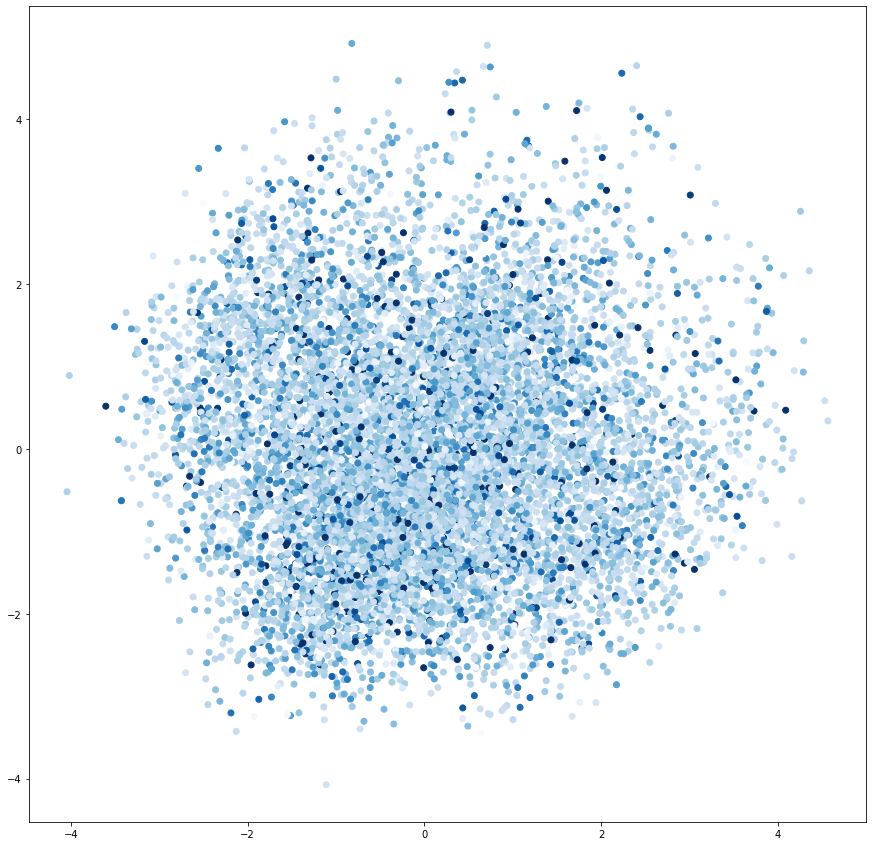

In [246]:
pca=PCA(n_components=2)
HOG_feature_2 = pca.fit_transform(HOG_feature)
plt.figure(figsize=(15,15))
plt.scatter(HOG_feature_2[:,0], HOG_feature_2[:,1], c=train_df['Pawpularity'].values, cmap='Blues')

In [70]:
train_df= train_df.merge(HOG_feature_df, on='Id')

In [71]:
train_df = get_train_data(train_df,train_df['Pawpularity'],n_splits=5,regression=True)

In [77]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
lgb_params = {"objective":"regression", 
              "metric":"mse", 
             'num_iterations':1000}
FIT_PARAMS_LGB = {"num_boost_round": 10000, "early_stopping_rounds": 100, "verbose_eval":100}
for fold in range(5):
    tr_df = train_df[train_df.fold!=fold].drop(columns=['path', 'mask_path', 'Id', 'image_size'])
    val_df =  train_df[train_df.fold==fold].drop(columns=['path', 'mask_path', 'Id', 'image_size'])
    tr_X, tr_y = np.array(tr_df.drop(columns='Pawpularity')), tr_df['Pawpularity'].values
    val_X, val_y = np.array(val_df.drop(columns='Pawpularity')), val_df['Pawpularity'].values
    sc = StandardScaler()
    tr_X = sc.fit_transform(tr_X)
    val_X = sc.fit_transform(val_X)
    train_data = lgb.Dataset(tr_X, label=tr_y)
    eval_data = lgb.Dataset(val_X, label=val_y, reference= train_data)
    model = lgb.train(lgb_params,train_data, **FIT_PARAMS_LGB, valid_names=['train', 'valid'], valid_sets=[train_data, eval_data],
    fobj=None) 
    y_pred = model.predict(val_X)
    score = np.sqrt(mean_squared_error(y_pred, val_y))
    print(score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134046
[LightGBM] [Info] Number of data points in the train set: 7929, number of used features: 539
[LightGBM] [Info] Start training from score 38.036196
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 138.734	valid's l2: 436.589
Early stopping, best iteration is:
[13]	train's l2: 353.212	valid's l2: 425.129
20.618646244504728
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134048
[LightGBM] [Info] Number of data points in the train set: 7929, number of used features: 539
[LightGBM] [Info] Start training from score 38.029638
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 139.662	valid's l

In [22]:
class PawpularDataset:
    def __init__(self, df, dense_features, targets, augmentations):
        self.image_paths = df['path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.dense_features = dense_features
        self.targets = targets
        if self.targets is None:
            self.targets = torch.ones(len(self.image_paths))
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[item])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        idx = np.where(mask > 127.5)
        h_max = idx[0].min()
        h_min = idx[0].max()
        w_max = idx[1].min()
        w_min = idx[1].max()
        
        image = image[h_max:h_min, w_max:w_min,:]
        mask = mask[h_max:h_min, w_max:w_min]
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        
        targets = self.targets[item]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        features = self.dense_features[item, :]
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "mask" : torch.tensor(mask, dtype=torch.float),
            "features": torch.tensor(features, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.float)
        }

In [9]:
class PawpularModel(nn.Module):
    def __init__(self, pet_classify_model, model_name):
        super().__init__()
        self.pet_classify_model = pet_classify_model
        self.pet_classify_model.requires_grad = False
        self.model = timm.create_model(model_name, pretrained=CONFIG.pretrained, in_chans=3)
#         self.model.patch_embed.proj=nn.Conv2d(4, 96, kernel_size=(4, 4), stride=(4, 4))
        self.model.head = nn.Linear(self.model.head.in_features, 128)
        self.dropout = nn.Dropout(0.1)
        self.dense1 = nn.Linear(177, 64)
        self.dense2 = nn.Linear(64, 1)

    def forward(self, image, features, mask=None):
        p = self.pet_classify_model(F.adaptive_avg_pool2d(image, (224,224)))
        p = torch.softmax(p, dim=1)
        x = self.model(image * (mask>0.5).unsqueeze(1))
        x = self.dropout(x)
        x = torch.cat([x, features, p], dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        return torch.sigmoid(x.squeeze(1))
    
class pet_categor_extract_model(nn.Module):
    def __init__(self,class_num):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=False, in_chans=3)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, 128)
        self.dropout = nn.Dropout(0.1)
        self.dense = nn.Linear(128
                               , class_num)

    def forward(self, image):
        x = self.model(image)
        x = self.dropout(x)
        x = self.dense(x)
        return x.squeeze(1)

In [10]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, batch_size, epoch, device):
    start = end = time.time()
    losses = AverageMeter()
    model.train()
    for iter, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        img, mask, feature ,target = data['image'],  data['mask'], data['features'], data['targets']
        img = img.to(device)
        mask = mask.to(device)
        feature = feature.to(device)
        target = target.to(device)
#         print(mask[0])
#         plt.figure(figsize=(2,2))
#         plt.imshow((img)[0].data.cpu().permute(1,2,0))
#         plt.show()
#         plt.figure(figsize=(2,2))
#         plt.imshow(mask[0].data.cpu(), cmap="gray")
#         plt.show()
#         plt.figure(figsize=(2,2))
#         plt.imshow((img * (mask>0.5).unsqueeze(1))[0].data.cpu().permute(1,2,0))
#         plt.show()
        y_preds = model(img, feature, mask)
        loss = criterion(y_preds, target)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        optimizer.step()
    scheduler.step()
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    start = end = time.time()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []

    for iter, data in enumerate(valid_loader):
        img, mask, feature ,target = data['image'], data['mask'], data['features'], data['targets']
        img = img.to(device)
        mask = mask.to(device)
        feature = feature.to(device)
        target = target.to(device)
        batch_size = target.size(0)

        # compute loss
        with torch.no_grad():
            y_preds = model(img, feature, mask)

        loss = criterion(y_preds, target)
        losses.update(loss.item(), batch_size)

        # record score
        preds.append(y_preds.to("cpu").numpy())

    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [11]:
def train_loop(train, fold_):
    LOGGER.info(f"========== fold: {fold_} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    cl_model = pet_categor_extract_model(class_num=37)
    cl_model.to(CONFIG.device)
    cl_model.load_state_dict(fix_model_state_dict(torch.load('../input/pretrained_models/efficientnet_b0_Oxford_classifier_size_224.pth')["model"]))

    model = PawpularModel(cl_model, model_name=CONFIG.MODEL_NAME)
    model.to(CONFIG.device)
    
    earlystopping= EarlyStopping(patience=3, path=CONFIG.OUTPUT_DIR / f"{CONFIG.MODEL_NAME}_{fold_}_latest.pth")
    
    if torch.cuda.device_count()>1:
        model=nn.DataParallel(model)
    dense_features = [
        'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
        'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
    ]
    train_idx = train[train.fold!=fold_].index
    val_idx = train[train.fold ==fold_].index
    train_folds = train.loc[train_idx].reset_index(drop=True)
    valid_folds = train.loc[val_idx].reset_index(drop=True)
    train_dataset = PawpularDataset(
        train_folds, 
        dense_features=train_folds[dense_features].values, targets=train_folds['Pawpularity']/100,
        augmentations=train_aug
    )
    
    val_dataset = PawpularDataset(
        valid_folds, 
        dense_features=valid_folds[dense_features].values, targets=valid_folds['Pawpularity']/100,
        augmentations=test_aug
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=4,
        drop_last=True,
    )
    valid_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG.batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=4,
        drop_last=False,
    )

    optimizer = optim.AdamW(model.parameters(), lr=CONFIG.lr)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-4)
    criterion = nn.BCELoss()
    metric = RMSE()
    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CONFIG.epoch):
        start_time = time.time()
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, CONFIG.batch_size, epoch, CONFIG.device)
#        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CONFIG.device)
        valid_labels = torch.tensor(valid_folds["Pawpularity"].values).float()
        score = metric(preds * 100, valid_labels)
        elapsed = time.time() - start_time
        
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  lr: {scheduler.get_lr()[0]:.8f} time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")
        if score < best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds * 100}, CONFIG.OUTPUT_DIR / f"{CONFIG.MODEL_NAME}_{fold_}_best.pth")
            
        earlystopping(avg_val_loss, model) #callメソッド呼び出し
        if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
            print("Early Stopping!")
            break
            
    check_point = torch.load(CONFIG.OUTPUT_DIR / f"{CONFIG.MODEL_NAME}_{fold_}_best.pth")

    valid_folds["preds"] = check_point["preds"]

    return valid_folds

In [12]:
def get_result(result_df):
    metric = RMSE()
    preds = result_df["Pawpularity"].values
    labels = result_df["preds"].values
    score = metric(preds, labels)
    LOGGER.info(f"Score: {score:<.5f}")

In [13]:
def inference():
    predictions = []
    dense_features = [
        'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
        'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
    ]
    test_dataset = PawpularDataset(
        test_df, 
        dense_features=test_df[dense_features].values, targets=None,
        augmentations=test_aug
    )
    test_loader = DataLoader(
        test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True
    )

    for fold in range(5):
        LOGGER.info(f"========== model: {CONFIG.MODEL_NAME} fold: {fold} inference ==========")
        cl_model = pet_categor_extract_model(class_num=37)
        cl_model.to(CONFIG.device)
        cl_model.load_state_dict(fix_model_state_dict(torch.load('../input/pretrained_models/efficientnet_b0_Oxford_classifier_size_224.pth')["model"]))

        model = PawpularModel(cl_model, model_name=CONFIG.MODEL_NAME)
        model.to(CONFIG.device)
        if torch.cuda.device_count()>1:
            model=nn.DataParallel(model)
            model.load_state_dict(torch.load(CONFIG.OUTPUT_DIR / f"{CONFIG.MODEL_NAME}_{fold}_best.pth")["model"])
        else:
            model.load_state_dict(fix_model_state_dict(torch.load(CONFIG.OUTPUT_DIR / f"{CONFIG.MODEL_NAME}_{fold}_best.pth")["model"]))
        model.eval()
        preds = []
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            img, mask, feature ,target = data['image'], data['mask'], data['features'], data['targets']
            img = img.to(CONFIG.device)
            mask= mask.to(CONFIG.device)
            feature = feature.to(CONFIG.device)
            target = target.to(CONFIG.device)
            with torch.no_grad():
                y_preds = model(img, feature, mask)
            preds.append(y_preds.to("cpu").numpy())
        preds = np.concatenate(preds)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)
    return predictions * 100

In [14]:
def main():
    # Training
    oof_df = pd.DataFrame()
    if CONFIG.training_step:
        for fold in range(CONFIG.fold):
            _oof_df = train_loop(train_df, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
        # Save OOF result
        oof_df.to_csv(CONFIG.OUTPUT_DIR / "oof_df.csv", index=False)
    else:
        oof_df = pd.read_csv(CONFIG.OUTPUT_DIR / "oof_df.csv")
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    # Inference
    predictions = inference()
    # submission
    submission = test_df.copy()
    submission["Pawpularity"] = predictions
    submission = submission[["Id", "Pawpularity"]]
    submission.to_csv(CONFIG.OUTPUT_DIR / "submission.csv", index=False)

In [15]:
if __name__ == "__main__":
    main()

========== CV ==========
Score: 17.54734
========== model: swin_large_patch4_window12_384 fold: 0 inference ==========
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window12_384_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window12_384_22kto1k.pth
100%|████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]
========== model: swin_large_patch4_window12_384 fold: 1 inference ==========
100%|████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]
========== model: swin_large_patch4_window12_384 fold: 2 inference ==========
100%|████████████████████████████| 1/1 [00:00<00:00,  3.39it/s]
========== model: swin_large_patch4_window12_384 fold: 3 inference ==========
100%|████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]
========== model: swin_large_patch4_window12_384 fold: 4 inference ==========
100%|████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]
